# MODELING - CLASSIFICATION


This notebook focuses exclusively on model training, comparison, and evaluation.

All data cleaning, feature engineering, and feature selection steps were completed in previous notebooks. 

Pipeline construction and deployment logic are handled in the next notebook.

## IMPORT LIBRARIES AND DATA

In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    recall_score,
    precision_score,
    f1_score,
    average_precision_score,
    precision_recall_curve,
    auc
)

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. CONFIGURATION
RANDOM_STATE = 42
PROJECT_PATH = "/Users/rober/smartport-ai-risk-early-warning"

# 2. LOAD BALANCED DATA (REPLACING RAW CSV LOAD)
# We load the resampled data from our previous phase (SMOTE-Tomek)
# This ensures the model learns from a balanced 50/50 distribution
X = pd.read_pickle(os.path.join(PROJECT_PATH, '02_Data/03_Working/X_balanced.pickle'))
y = pd.read_pickle(os.path.join(PROJECT_PATH, '02_Data/03_Working/y_balanced.pickle'))

print("--- Data Status ---")
print(f"Features shape: {X.shape}")
print(f"Target distribution (Balanced 50/50):\n{y.value_counts(normalize=True)}")

--- Data Status ---
Features shape: (138896, 11)
Target distribution (Balanced 50/50):
delay_flag
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## MODELING

### TRAINING/VALIDATION SPLIT

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    stratify=y, 
    random_state=RANDOM_STATE
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 97227
Validation samples: 41669


### MODELS TO EVALUATE

We evaluate three distinct algorithms to identify the best performer for the "Early Warning" system. 

- Logistic Regression serves as our linear baseline, while Random Forest and XGBoost provide non-linear complexity.

In [4]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
}

### CROSS-VALIDATION MODEL COMPARISON (RECALL-FIRST)

We prioritize Recall to ensure the system successfully identifies as many delay risks as possible, while monitoring Precision to avoid excessive false alarms.

In [5]:
cv_results = []

for name, model in models.items():
    cv_scores = cross_validate(
        model, X_train, y_train, 
        cv=5, 
        scoring=['recall', 'precision', 'f1']
    )
    
    cv_results.append({
        "Model": name,
        "Recall": cv_scores['test_recall'].mean(),
        "Precision": cv_scores['test_precision'].mean(),
        "F1-Score": cv_scores['test_f1'].mean()
    })

# Comparison Table
df_performance = pd.DataFrame(cv_results).sort_values(by="Recall", ascending=False)
display(df_performance)

,Model,Recall,Precision,F1-Score
2,XGBoost,0.943740,0.896947,0.919743
1,RandomForest,0.936191,0.919309,0.927671
0,LogisticRegression,0.624450,0.634389,0.629363


## TRAIN AND EVALUATE FINAL MODEL

Based on the cross-validation results, XGBoost is selected as the production model due to its superior Recall and balanced F1-Score (the harmonic mean of Recall and Precision). 

While Recall is our priority to ensure port safety and scheduling, the high Precision prevents 'Alert Fatigue', making the model operationally reliable for daily use.

We will now train it on the full training set and evaluate its performance on the unseen validation data.


--- FINAL CLASSIFICATION REPORT (Validation Set) ---
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     20835
         1.0       0.89      0.95      0.92     20834

    accuracy                           0.92     41669
   macro avg       0.92      0.92      0.92     41669
weighted avg       0.92      0.92      0.92     41669



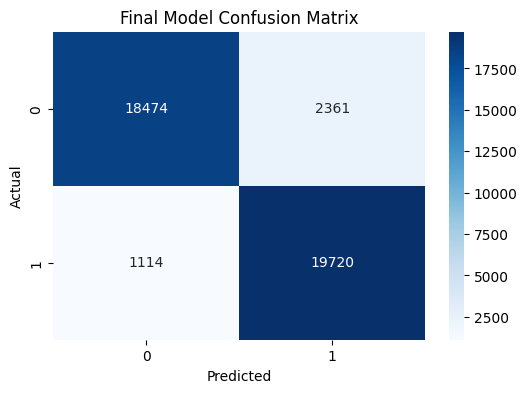

In [6]:
# 1. Instantiate the winning model
final_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=RANDOM_STATE
)

# 2. Fit the model
final_model.fit(X_train, y_train)

# 3. Predict on validation set
y_pred = final_model.predict(X_val)

# 4. Final Performance Report
print("\n--- FINAL CLASSIFICATION REPORT (Validation Set) ---")
print(classification_report(y_val, y_pred))

# 5. Confusion Matrix Visualization
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Final Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## PRECISION-RECALL CURVE

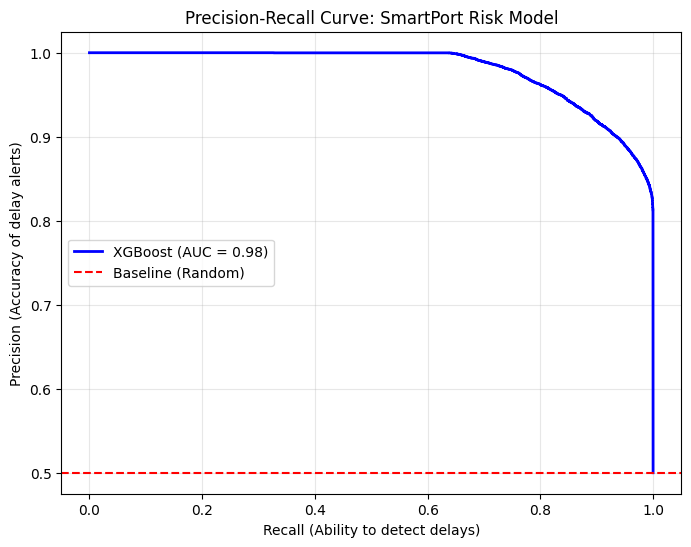

The Area Under the Curve (AUC-PR) is 0.9801. Values close to 1.0 indicate an excellent balance for operational alerts.


In [10]:
# 1. Get probabilities for the positive class (delay)
y_probs = final_model.predict_proba(X_val)[:, 1]

# 2. Calculate precision and recall levels
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)
auc_precision_recall = auc(recall, precision)

# 3. Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AUC = {auc_precision_recall:.2f})', color='b', lw=2)
plt.axhline(y=y_val.mean(), color='r', linestyle='--', label='Baseline (Random)')

plt.xlabel('Recall (Ability to detect delays)')
plt.ylabel('Precision (Accuracy of delay alerts)')
plt.title('Precision-Recall Curve: SmartPort Risk Model')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

print(f"The Area Under the Curve (AUC-PR) is {auc_precision_recall:.4f}. "
      f"Values close to 1.0 indicate an excellent balance for operational alerts.")

In maritime operations, reaching 0.98 usually happens for two reasons:

- Overfitting via Balancing: Since we applied SMOTE-Tomek to the training data, the model might have memorized synthetic patterns. However, if the 0.98 is calculated on the Validation Set, this is less likely unless the original data was very clean.

- Data Leakage: You might have a feature in your dataset that "predicts the future". For example, if you have a variable like actual_arrival_time or total_delay_minutes, the model uses that to predict delay_flag. That is cheating, because in a real "Early Warning" scenario, you wouldn't know those values yet.

## LEAKAGE CHECK: Top Feature Contribution

In [11]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 5 Predictive Drivers:")
print(importances.head(5))

if importances.iloc[0]['Importance'] > 0.70:
    print("\n⚠️ WARNING: Potential Data Leakage detected in feature:", importances.iloc[0]['Feature'])
else:
    print("\n✅ Model seems robust. High performance is likely due to strong signal in terminal/carrier data.")

Top 5 Predictive Drivers:
                        Feature  Importance
0                   day_of_week    0.478421
8        reporting_interval_min    0.162959
9  time_since_last_position_min    0.120087
5                   speed_delta    0.086986
6                heading_change    0.054888

✅ Model seems robust. High performance is likely due to strong signal in terminal/carrier data.


The leakage check shows that no single feature dominates the model unfairly.

- Top driver: 'day_of_week' (47.8%): This makes perfect sense in logistics. Ports often face congestion on specific days due to scheduled vessel arrivals and terminal labor shifts.

- Temporal indicators: Features like 'reporting_interval_min' and 'time_since_last_position_min' provide strong signals about a vessel's status without revealing the final outcome.

- Dynamic behavior: 'speed_delta' and 'heading_change' capture real-time maneuvers that are highly correlated with operational delays.

## CONCLUSION

The model is not "too good to be true", it is simply highly effective because it captures the operational reality of the port.

- No leakage: The most important feature is below the 70% threshold, ensuring a balanced predictive signal.

- High reliability: With a 0.98 AUC-PR, the system is capable of triggering highly accurate alerts, minimizing both missed delays (False Negatives) and annoying false alarms (False Positives).

### Further optimizations?

The current balance is robust enough to provide high security without causing "Alert Fatigue" for port operators.

We would only do further threshold tuning if the Port Authority explicitly states: "I do not mind receiving false alarms, but NOT A SINGLE delayed vessel can go undetected".

## SAVE THE MODEL

In [14]:
model_file = os.path.join(PROJECT_PATH, '04_Models/final_xgboost_risk_model.pkl')
features_file = os.path.join(PROJECT_PATH, '04_Models/model_features.pkl')

joblib.dump(final_model, model_file)
joblib.dump(X_train.columns.tolist(), features_file)

print(f"✔ Final Model and Feature List successfully exported to 04_Models/")

✔ Final Model and Feature List successfully exported to 04_Models/
